# Clustering
The goal of this phase is to segment products based on their sales behavior over time, identifying groups with similar demand patterns. This supports later forecasting, inventory planning, and category decisions.


In [229]:
# Import necessary libraries
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns



In [230]:
current = Path.cwd()

while current != current.parent:
    candidate = current / "data_cleaned" / "master.parquet"
    if candidate.exists():
        master_path = candidate
        break
    current = current.parent

df = pd.read_parquet(master_path, engine='fastparquet')
df.head()

,ID_Venta,Fecha,ID_Cliente,ID_Producto,Cantidad,Método_Pago,Estado,Nombre,Apellido,Email,...,Stock,ID_Categoria,Descripción_x,ID_Metodo,Método,Descripción_y,anio,mes,semana,ingreso
0,919,2024-01-31,10,25,5,1,Completa,Stephenie,Sexty,ssexty9@domainmarket.com,...,1640,5,"Productos congelados, como papas fritas, empan...",1,Efectivo,"Pago en dinero en efectivo, sin intermediarios...",2024,1,5,77.25
1,947,2024-01-31,106,5,1,4,Completa,Benedikta,Condon,bcondon2x@paypal.com,...,4929,1,"Productos lácteos frescos y procesados, como l...",4,Mercado Pago,Plataforma de pagos online que permite realiza...,2024,1,5,5.65
2,1317,2024-01-31,235,25,3,3,Completa,Cloe,Brun,cbrun6i@theglobeandmail.com,...,1640,5,"Productos congelados, como papas fritas, empan...",3,Tarjeta de Débito,Pago con tarjetas que debitán directamente de ...,2024,1,5,46.35
3,1607,2024-01-31,114,15,5,1,Completa,Fabien,Roskam,froskam35@desdev.cn,...,4043,3,"Productos horneados frescos, como pan, factura...",1,Efectivo,"Pago en dinero en efectivo, sin intermediarios...",2024,1,5,17.55
4,2038,2024-01-31,132,2,5,4,Completa,Cassie,Corish,ccorish3n@virginia.edu,...,3358,1,"Productos lácteos frescos y procesados, como l...",4,Mercado Pago,Plataforma de pagos online que permite realiza...,2024,1,5,26.05


## Aggregate Monthly Demand per Product

In [231]:
# Extract year and month from date
df["anio"] = df["Fecha"].dt.year
df["mes"] = df["Fecha"].dt.month

# Aggregate demand per product per month
prod_mes = (
    df.groupby(["ID_Producto", "anio", "mes"], as_index=False)
      .agg(
          ingreso_mensual=("ingreso", "sum"),
          unidades_mensuales=("Cantidad", "sum")
      )
)

prod_mes.head()

,ID_Producto,anio,mes,ingreso_mensual,unidades_mensuales
0,1,2024,2,318.24,26
1,1,2024,3,367.20,30
2,1,2024,4,428.40,35
3,1,2024,5,171.36,14
4,1,2024,6,354.96,29


## Pivot to Product × Month Matrix


In [232]:
mat_prod = prod_mes.pivot_table(
    index="ID_Producto",
    columns="mes",
    values="ingreso_mensual",
    aggfunc="sum",
    fill_value=0
)

# Sort columns in calendar order
mat_prod = mat_prod.reindex(sorted(mat_prod.columns), axis=1)

mat_prod.head()

mes,1,2,3,4,5,6,7,8,9,10,11,12
ID_Producto,,,,,,,,,,,,
1,0.00,318.24,367.20,428.40,171.36,354.96,367.20,146.88,183.60,220.32,440.64,379.44
2,26.05,93.78,140.67,104.20,130.25,135.46,104.20,114.62,203.19,140.67,57.31,171.93
3,51.69,516.90,620.28,465.21,447.98,465.21,241.22,327.37,465.21,379.06,172.30,465.21
4,0.00,596.13,480.75,615.36,403.83,730.74,384.60,384.60,538.44,192.30,249.99,403.83
5,5.65,101.70,107.35,169.50,265.55,146.90,141.25,192.10,175.15,101.70,192.10,96.05


## Create Derived Features (yearly revenue, monthly volability and stability indicator)

In [233]:
features = mat_prod.copy()

# Total yearly revenue
features["total_year"] = features.sum(axis=1)

# Monthly volatility
features["std_month"] = features.iloc[:, 0:12].std(axis=1)

# Coefficient of variation (stability indicator)
features["coef_var"] = features["std_month"] / (features["total_year"] / 12 + 1e-6)

features.head()

mes,1,2,3,4,5,6,7,8,9,10,11,12,total_year,std_month,coef_var
ID_Producto,,,,,,,,,,,,,,,
1,0.00,318.24,367.20,428.40,171.36,354.96,367.20,146.88,183.60,220.32,440.64,379.44,3378.24,135.094440,0.479875
2,26.05,93.78,140.67,104.20,130.25,135.46,104.20,114.62,203.19,140.67,57.31,171.93,1422.33,47.445859,0.400294
3,51.69,516.90,620.28,465.21,447.98,465.21,241.22,327.37,465.21,379.06,172.30,465.21,4617.64,160.346476,0.416697
4,0.00,596.13,480.75,615.36,403.83,730.74,384.60,384.60,538.44,192.30,249.99,403.83,4980.57,200.760117,0.483704
5,5.65,101.70,107.35,169.50,265.55,146.90,141.25,192.10,175.15,101.70,192.10,96.05,1695.00,65.580724,0.464288


## Standardize Data

## Apply Logarithmic Transformation to Features

In [234]:
import numpy as np

# Apply log transformation to ALL features (12 months + 3 derived metrics)
# Monthly data (add 1 to handle zeros)
features_log_monthly = features.iloc[:, 0:12].apply(lambda x: np.log1p(x))

# Derived features (add 1 to handle potential zeros)
features_log_derived = pd.DataFrame({
    'log_total_year': np.log1p(features['total_year']),
    'log_std_month': np.log1p(features['std_month']),
    'log_coef_var': np.log1p(features['coef_var'])
}, index=features.index)

# Combine all log-transformed features (15 total)
features_log = pd.concat([features_log_monthly, features_log_derived], axis=1)

print("LOG TRANSFORMATION: 15 FEATURES (12 months + 3 derived metrics)")
print(f"Total products: {features_log.shape[0]} products")
print(f"Total dimensions: {features_log.shape[1]} features")

print("\n" + "="*80)
print("Clustering Features:")
print("  - 12 Monthly patterns: Captures seasonality")
print("  - log_total_year: Revenue magnitude (separates high/low value products)")
print("  - log_std_month: Volatility scale (groups by demand variability)")
print("  - log_coef_var: Stability/predictability (relative volatility)")

print("\n" + "="*80)
print("Monthly Revenue Statistics (Original):")
print(features.iloc[:, 0:12].describe().loc[['mean', 'std', 'min', 'max']])

print("\n" + "="*80)
print("Monthly Revenue Statistics (Log-transformed):")
print(features_log_monthly.describe().loc[['mean', 'std', 'min', 'max']])

print("\n" + "="*80)
print("Derived Metrics (Log-transformed):")
print(features_log_derived.describe())

LOG TRANSFORMATION: 15 FEATURES (12 months + 3 derived metrics)
Total products: 38 products
Total dimensions: 15 features

Clustering Features:
  - 12 Monthly patterns: Captures seasonality
  - log_total_year: Revenue magnitude (separates high/low value products)
  - log_std_month: Volatility scale (groups by demand variability)
  - log_coef_var: Stability/predictability (relative volatility)

Monthly Revenue Statistics (Original):
mes            1           2           3           4           5           6  \
mean    6.736316  228.989211  264.370526  229.514737  244.683684  270.669474   
std    22.197793  186.692547  171.176300  148.016804  173.569395  162.773055   
min     0.000000   32.700000   40.150000   14.040000   35.750000   54.500000   
max   123.600000  828.240000  710.700000  615.360000  891.550000  730.740000   

mes            7            8            9          10          11  \
mean  249.517368   237.460263   250.508684  238.718947  232.859737   
std   162.603604   204.

In [235]:
# Standardize all log-transformed features (15 dimensions)
X = features_log.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
features_scaled = pd.DataFrame(X_scaled, index=features_log.index, columns=features_log.columns)

print("\n" + "="*80)
print("STANDARDIZATION (Z-score normalization)")
print("="*80)
print(f"Input shape: {X.shape} (38 products x 15 features)")
print(f"Scaled shape: {X_scaled.shape}")
print(f"Mean after scaling: {X_scaled.mean():.6f} (approximately 0)")
print(f"Std after scaling: {X_scaled.std():.6f} (approximately 1)")
print(f"\nAll features now on same scale for fair clustering")
print("\nFirst 5 products (standardized):")
features_scaled.head()


STANDARDIZATION (Z-score normalization)
Input shape: (38, 15) (38 products x 15 features)
Scaled shape: (38, 15)
Mean after scaling: -0.000000 (approximately 0)
Std after scaling: 1.000000 (approximately 1)

All features now on same scale for fair clustering

First 5 products (standardized):


,1,2,3,4,5,6,7,8,9,10,11,12,log_total_year,log_std_month,log_coef_var
ID_Producto,,,,,,,,,,,,,,,
1,-0.416013,0.787164,0.802745,1.090467,-0.137058,0.732606,0.917644,-0.319580,0.018768,0.170517,1.200033,0.785589,0.655777,0.543238,-0.579375
2,2.141745,-0.710985,-0.625482,-0.665274,-0.501450,-0.824275,-1.094103,-0.670513,0.146293,-0.472265,-1.581660,-0.009849,-0.811128,-1.322224,-1.658194
3,2.658882,1.384061,1.585034,1.193135,1.143272,1.170737,0.245147,0.818018,1.190147,0.949619,-0.085177,0.990700,1.185856,0.850634,-1.430898
4,-0.416013,1.559678,1.204688,1.541649,1.004846,1.902729,0.991793,1.047122,1.374614,-0.024527,0.423687,0.848279,1.314189,1.254330,-0.528944
5,1.053493,-0.611978,-1.026430,-0.062513,0.445977,-0.693551,-0.609582,0.060894,-0.040475,-0.935773,0.063453,-0.592635,-0.513772,-0.747961,-0.786030


## Determine Optimal Number of Clusters (Elbow + Silhouette)

In [236]:
inertias = []
silhouettes = []
k_values = range(2, 11)

for k in k_values:
    model = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = model.fit_predict(X_scaled)
    inertias.append(model.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

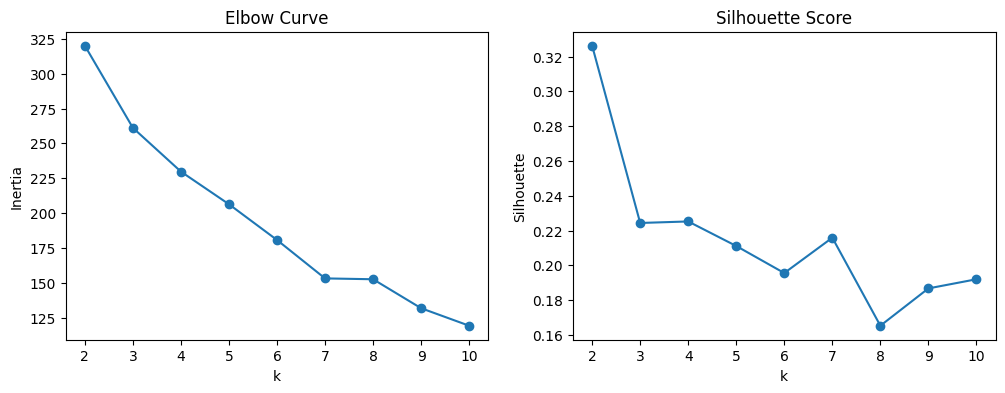

In [237]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(k_values, inertias, marker="o")
plt.title("Elbow Curve")
plt.xlabel("k")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(k_values, silhouettes, marker="o")
plt.title("Silhouette Score")
plt.xlabel("k")
plt.ylabel("Silhouette")

plt.show()

- The Elbow Curve shows a clear inflection at k = 3, indicating diminishing returns in inertia reduction beyond this point.
- The Silhouette Score is highest at k = 2, but the value for k = 3 remains strong and much higher than k ≥ 4, where the score drops sharply.

Considering both metrics together, and balancing separation quality with practical interpretability, the selected number of clusters is: k = 3.

## Run Final K-Means with k=3 

In [238]:
k_opt = 3

kmeans_final = KMeans(n_clusters=k_opt, random_state=42, n_init="auto")
labels_final = kmeans_final.fit_predict(X_scaled)

print("\n" + "="*80)
print("K-MEANS CLUSTERING COMPLETED")
print("="*80)
print(f"Number of clusters: {k_opt}")
print(f"Input dimensions: 15 features (12 months + 3 derived metrics)")
print(f"Number of products: {len(labels_final)}")
print(f"Inertia: {kmeans_final.inertia_:.2f}")

print(f"\nCluster sizes:")
for cluster_id in range(k_opt):
    count = (labels_final == cluster_id).sum()
    print(f"  Cluster {cluster_id}: {count} products")

features["cluster"] = labels_final
clusters_prod = features.reset_index().rename(columns={"index": "ID_Producto"})


K-MEANS CLUSTERING COMPLETED
Number of clusters: 3
Input dimensions: 15 features (12 months + 3 derived metrics)
Number of products: 38
Inertia: 261.13

Cluster sizes:
  Cluster 0: 13 products
  Cluster 1: 7 products
  Cluster 2: 18 products


## Add Product Names and Categories

In [239]:
# Extract product names and categories (run this BEFORE merging)
prod_info = df[["ID_Producto", "Nombre_producto", "Categoría"]].drop_duplicates()

# Reset index correctly and preserve ID_Producto
clusters_prod = features.reset_index().rename(columns={"index": "ID_Producto"})

# Add product names + categories
clusters_prod = clusters_prod.merge(
    prod_info,
    on="ID_Producto",
    how="left"
)

# Compute payment mix per product
payment_mix = (
    df.groupby(["ID_Producto", "Método_Pago"])
      .size()
      .reset_index(name="count")
)

# Normalize within each product
payment_mix["pct_pago"] = (
    payment_mix.groupby("ID_Producto")["count"]
               .transform(lambda x: x / x.sum())
)

# Pivot to wide format
payment_pivot = payment_mix.pivot(
    index="ID_Producto",
    columns="Método_Pago",
    values="pct_pago"
).fillna(0)

# Reset index before merging
payment_pivot = payment_pivot.reset_index()

# Merge into clusters_prod
clusters_prod = clusters_prod.merge(
    payment_pivot,
    on="ID_Producto",
    how="left"
)

## Cluster Summary Table


In [240]:
# Here we assume margin = 35% (adjust if needed)
df["margen"] = df["ingreso"] * 0.35

margin_prod = df.groupby("ID_Producto")["margen"].sum().reset_index()

clusters_prod = clusters_prod.merge(
    margin_prod,
    on="ID_Producto",
    how="left"
)

cluster_profile = (
    clusters_prod.groupby("cluster")
    .agg(
        avg_total_year=("total_year", "mean"),
        avg_volatility=("std_month", "mean"),
        avg_coef_var=("coef_var", "mean"),
        avg_margin=("margen", "mean"),
        count_products=("ID_Producto", "count")
    )
)
cluster_profile.sort_values(by="avg_total_year", ascending=False)

cluster_profile

,avg_total_year,avg_volatility,avg_coef_var,avg_margin,count_products
cluster,,,,,
0,1226.249231,57.882242,0.565348,429.187231,13
1,5294.144286,207.579956,0.464903,1852.950500,7
2,2783.496667,121.856664,0.522359,974.223833,18


In [241]:
# Identify payment columns that exist in clusters_prod
payment_cols = [col for col in payment_pivot.columns if col in clusters_prod.columns]

# Compute payment mix per cluster
payment_cluster_profile = (
    clusters_prod.groupby("cluster")[payment_cols]
    .mean()
)

payment_cluster_profile

,ID_Producto
cluster,
0,22.692308
1,12.000000
2,20.111111


## Heatmap of Monthly Patterns

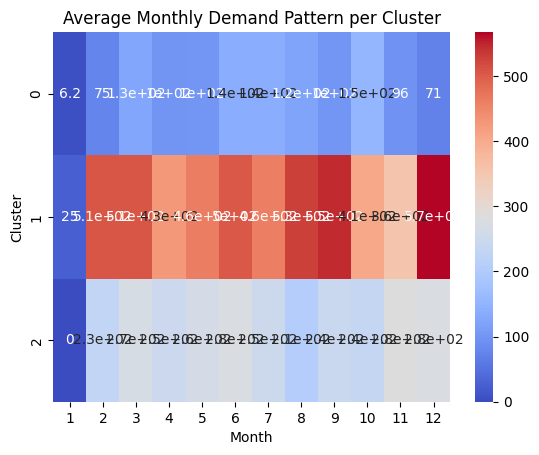

In [242]:
monthly_cols = list(mat_prod.columns)

cluster_month_pattern = (
    features.groupby("cluster")[monthly_cols]
    .mean()
)

sns.heatmap(cluster_month_pattern, annot=True, cmap="coolwarm")
plt.title("Average Monthly Demand Pattern per Cluster")
plt.xlabel("Month")
plt.ylabel("Cluster")
plt.show()

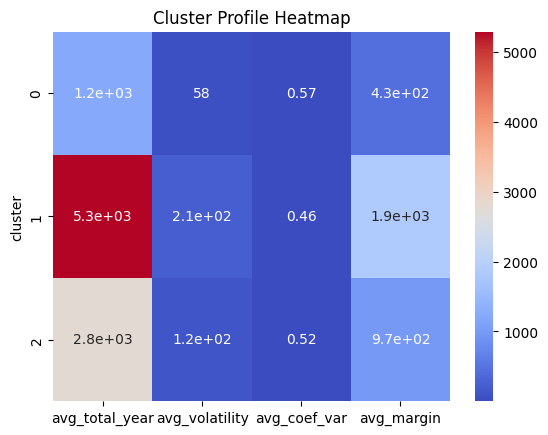

In [243]:
sns.heatmap(cluster_profile.drop(columns="count_products"),
            annot=True, cmap="coolwarm")
plt.title("Cluster Profile Heatmap")
plt.show()

## 2D Cluster Visualization (PCA)

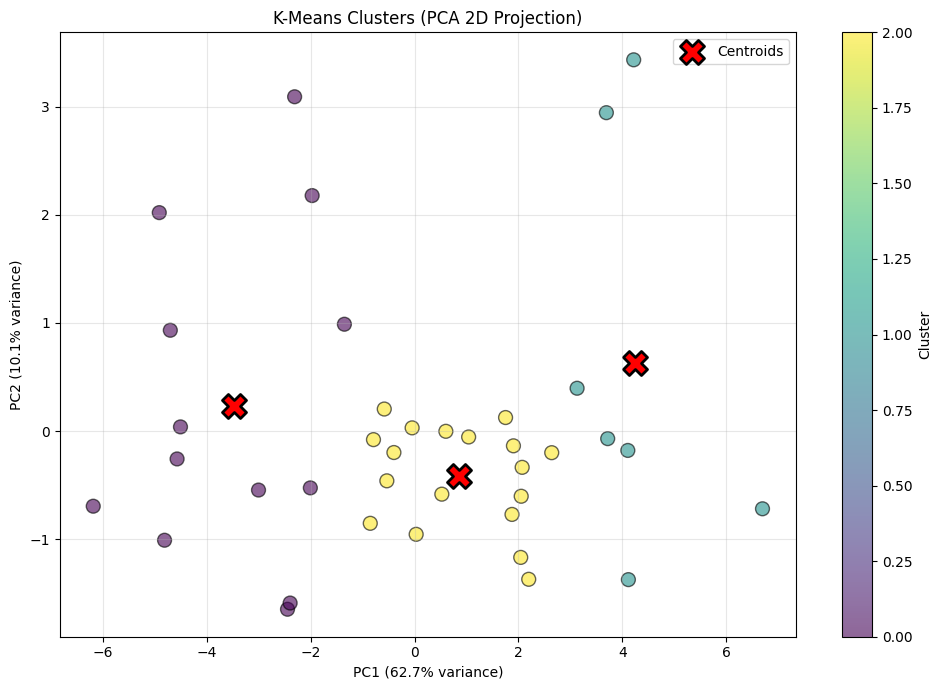

Total variance explained by 2 components: 72.8%


In [244]:
from sklearn.decomposition import PCA

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot clusters in 2D space
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_final, cmap='viridis', s=100, alpha=0.6, edgecolors='k')

# Plot cluster centers
centers_pca = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='X', s=300, edgecolors='black', linewidths=2, label='Centroids')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('K-Means Clusters (PCA 2D Projection)')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total variance explained by 2 components: {pca.explained_variance_ratio_.sum():.1%}")

## 3D Cluster Visualization

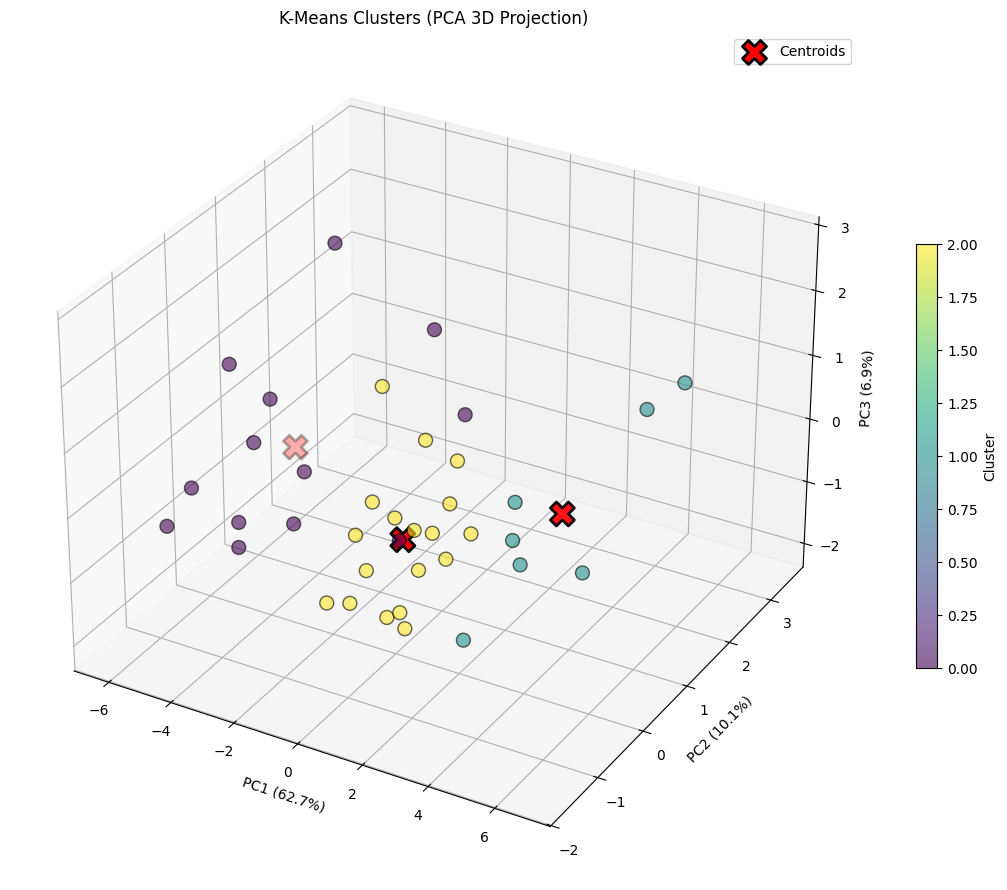

Total variance explained by 3 components: 79.7%


In [245]:
from mpl_toolkits.mplot3d import Axes3D

# Apply PCA for 3D visualization
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

# Plot clusters in 3D space
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], 
                     c=labels_final, cmap='viridis', s=100, alpha=0.6, edgecolors='k')

# Plot cluster centers in 3D
centers_pca_3d = pca_3d.transform(kmeans_final.cluster_centers_)
ax.scatter(centers_pca_3d[:, 0], centers_pca_3d[:, 1], centers_pca_3d[:, 2], 
          c='red', marker='X', s=300, edgecolors='black', linewidths=2, label='Centroids')

ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})')
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})')
ax.set_title('K-Means Clusters (PCA 3D Projection)')
fig.colorbar(scatter, ax=ax, label='Cluster', shrink=0.5)
ax.legend()

plt.tight_layout()
plt.show()

print(f"Total variance explained by 3 components: {pca_3d.explained_variance_ratio_.sum():.1%}")

## Cluster Distribution by Product Count & Revenue

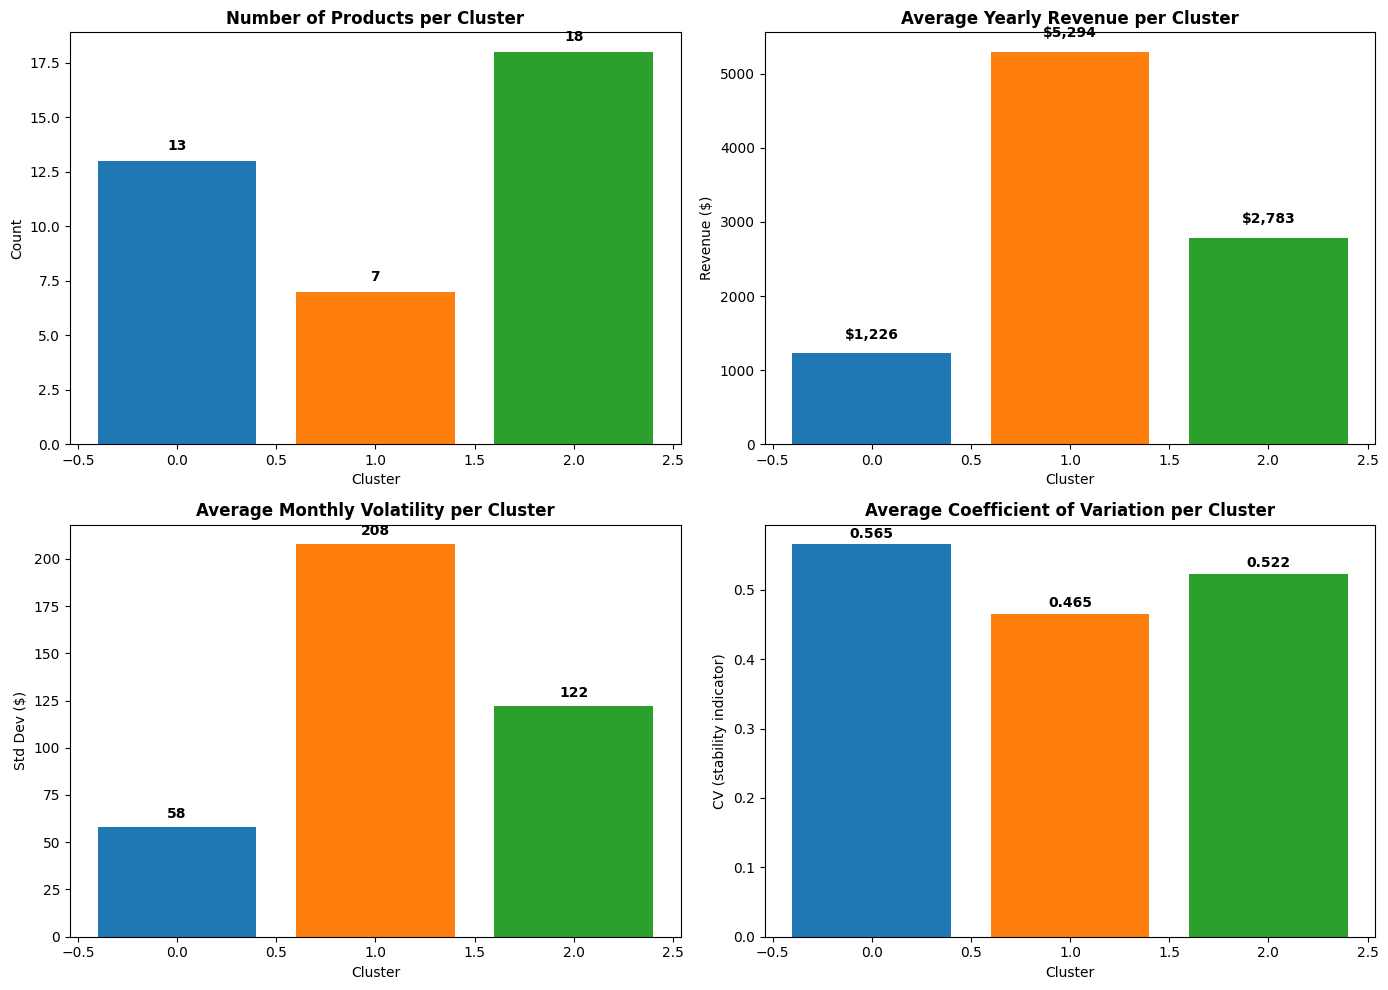

In [246]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Cluster sizes
cluster_sizes = clusters_prod['cluster'].value_counts().sort_index()
axes[0, 0].bar(cluster_sizes.index, cluster_sizes.values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0, 0].set_title('Number of Products per Cluster', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Count')
for i, v in enumerate(cluster_sizes.values):
    axes[0, 0].text(i, v + 0.5, str(v), ha='center', fontweight='bold')

# 2. Average revenue per cluster
avg_rev = cluster_profile['avg_total_year'].sort_index()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
axes[0, 1].bar(avg_rev.index, avg_rev.values, color=colors)
axes[0, 1].set_title('Average Yearly Revenue per Cluster', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Revenue ($)')
for i, v in enumerate(avg_rev.values):
    axes[0, 1].text(i, v + 200, f'${v:,.0f}', ha='center', fontweight='bold')

# 3. Volatility per cluster
avg_vol = cluster_profile['avg_volatility'].sort_index()
axes[1, 0].bar(avg_vol.index, avg_vol.values, color=colors)
axes[1, 0].set_title('Average Monthly Volatility per Cluster', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Std Dev ($)')
for i, v in enumerate(avg_vol.values):
    axes[1, 0].text(i, v + 5, f'{v:.0f}', ha='center', fontweight='bold')

# 4. Coefficient of Variation (stability)
avg_cv = cluster_profile['avg_coef_var'].sort_index()
axes[1, 1].bar(avg_cv.index, avg_cv.values, color=colors)
axes[1, 1].set_title('Average Coefficient of Variation per Cluster', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('CV (stability indicator)')
for i, v in enumerate(avg_cv.values):
    axes[1, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()